In [1]:
import os
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

import matplotlib.pyplot as plt
import time

In [2]:
imdb_dir = './datasets/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [3]:
maxlen = 100
training_samples = 200
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('%s개의 고유한 토큰을 찾았습니다.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('데이터 텐서의 크기:', data.shape)
print('레이블 텐서의 크기:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

88582개의 고유한 토큰을 찾았습니다.
데이터 텐서의 크기: (25000, 100)
레이블 텐서의 크기: (25000,)


In [4]:
glove_dir = './datasets/glove/'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('%s개의 단어 벡터를 찾았습니다.' % len(embeddings_index))

400000개의 단어 벡터를 찾았습니다.


In [5]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [6]:
start = time.time()

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1000000   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                320032    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


2022-06-29 00:24:36.937176: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-29 00:24:36.937256: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [8]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('./models/pre_trained_glove_model.h5')

2022-06-29 00:24:37.316448: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-29 00:24:37.316619: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-29 00:24:37.449199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/10
7/7 [==============================] - ETA: 0s - loss: 1.2564 - acc: 0.5000

2022-06-29 00:24:37.738469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 1s 188ms/step - loss: 1.2564 - acc: 0.5000 - val_loss: 0.6927 - val_acc: 0.5034
Epoch 2/10
7/7 [==============================] - 1s 169ms/step - loss: 0.6981 - acc: 0.6300 - val_loss: 0.7561 - val_acc: 0.5045
Epoch 3/10
7/7 [==============================] - 1s 176ms/step - loss: 0.5870 - acc: 0.6000 - val_loss: 0.6907 - val_acc: 0.5540
Epoch 4/10
7/7 [==============================] - 1s 187ms/step - loss: 0.4448 - acc: 0.8400 - val_loss: 0.6869 - val_acc: 0.5647
Epoch 5/10
7/7 [==============================] - 1s 166ms/step - loss: 0.3429 - acc: 0.8500 - val_loss: 1.3810 - val_acc: 0.4961
Epoch 6/10
7/7 [==============================] - 1s 167ms/step - loss: 0.2098 - acc: 0.9600 - val_loss: 0.7166 - val_acc: 0.5756
Epoch 7/10
7/7 [==============================] - 1s 168ms/step - loss: 0.1659 - acc: 0.9550 - val_loss: 1.6796 - val_acc: 0.4962
Epoch 8/10
7/7 [==============================] - 1s 168ms/step - loss: 0.1725 - acc: 0.9300 - val_lo

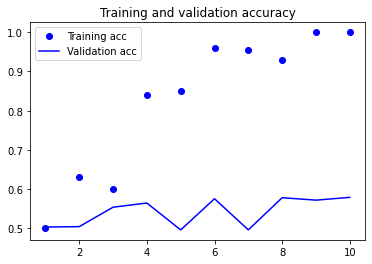

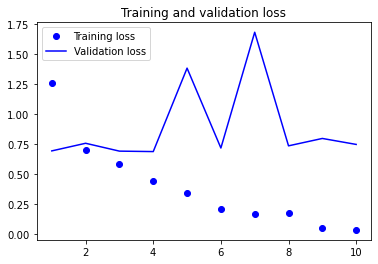

elapsed time: 11.265244007110596


In [9]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

print(f"elapsed time: {time.time() - start}")

In [10]:
start = time.time()

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('./models/pre_trained_glove_model.h5')

Epoch 1/10
1/7 [===>..........................] - ETA: 1s - loss: 0.6912 - acc: 0.5000

2022-06-29 00:24:48.394136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 0.6923 - acc: 0.5350

2022-06-29 00:24:48.688085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 1s 194ms/step - loss: 0.6923 - acc: 0.5350 - val_loss: 0.6958 - val_acc: 0.4972
Epoch 2/10
7/7 [==============================] - 1s 175ms/step - loss: 0.4814 - acc: 0.9700 - val_loss: 0.7083 - val_acc: 0.5019
Epoch 3/10
7/7 [==============================] - 1s 174ms/step - loss: 0.2856 - acc: 1.0000 - val_loss: 0.7299 - val_acc: 0.4986
Epoch 4/10
7/7 [==============================] - 1s 176ms/step - loss: 0.1436 - acc: 1.0000 - val_loss: 0.7445 - val_acc: 0.5069
Epoch 5/10
7/7 [==============================] - 1s 174ms/step - loss: 0.0739 - acc: 1.0000 - val_loss: 0.7637 - val_acc: 0.5048
Epoch 6/10
7/7 [==============================] - 1s 174ms/step - loss: 0.0383 - acc: 1.0000 - val_loss: 0.7619 - val_acc: 0.5034
Epoch 7/10
7/7 [==============================] - 1s 177ms/step - loss: 0.0206 - acc: 1.0000 - val_loss: 0.7872 - val_acc: 0.5034
Epoch 8/10
7/7 [==============================] - 1s 175ms/step - loss: 0.0115 - acc: 1.0000 - val_lo

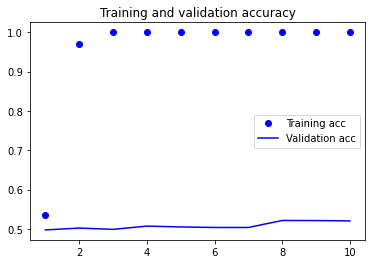

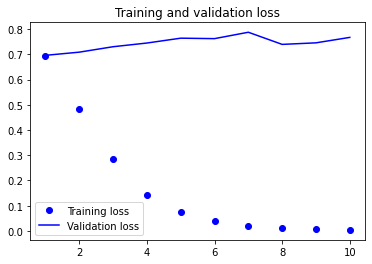

elapsed time: 11.236049175262451


In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

print(f"elapsed time: {time.time() - start}")

In [13]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding="utf8")
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [14]:
model.load_weights('./models/pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

782/782 [==============================] - 3s 4ms/step - loss: 0.7676 - acc: 0.5207


[0.7675742506980896, 0.5207200050354004]